# MNIST CNN-AE
## Image restoration on the MNIST dataset using a Convolutional Auto-Encoder

#### Table of Contents
1. [Dataset](#Dataset)
2. [Training](#Training)
3. [Testing](#Testing)


# Dataset

Images from the MNIST dataset were corrupted by adding white squares that are at most 25% of the area of the original image. Both the training image set (60,000 images) and the testing image set (10,000 images) were used. The categorical labels were dropped since they did not contain any image data.

The images below are taken from the training image set.

<img src="./images/dataset.png" width="640">

The corrupted images were used as the inputs to the auto-encoder and the clean versions of the images were used the labels. 

```python
(x_train, _), (x_test, _) = mnist.load_data()

x_train_corrupted = corrupt_mnist_copy(x_train)
x_test_corrupted = corrupt_mnist_copy(x_test)

.
.
.

history = autoencoder.fit(x_train_corrupted, x_train, batch_size = batch_size, epochs=epochs, verbose=1,
         validation_data=(x_test_corrupted, x_test), callbacks=callbacks)
```

# Training

The architecture used for the auto-encoder is a convolutional neural network since CNNs have been shown to be more effective when used for image processing tasks. 

In [2]:
# fix for memory issues
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import keras
model = tf.keras.models.load_model("domingo_cnn_ae.h5")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 16)        0   

Two layers were used in the encoder as adding more maxpooling layers would compress the dimensions of the filters down to 4x4 pixels, which cannot be upscaled back to the original image dimensions. It follows that two layers were also used in the decoder. 

## Hyperparameters

Adam was used as the optimizer with the initial learning rate $\alpha$ set to 0.01. The first-moment decay rate $\beta_{1}$ and second-moment decay rate $\beta_{2}$ were left at the default values of 0.9 and 0.999 respectively.

Binary cross-entropy was used to measure the loss and binary accuracy was used as the performance metric to make sure the predictions match the labels.

The batch size was set to 64 and training was set to run for 250 epochs.

# Losses and Metrics

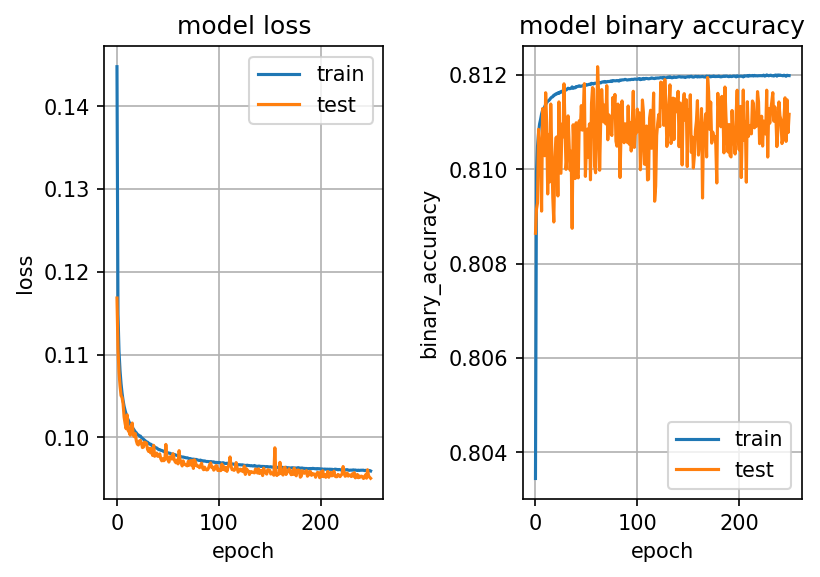

In [4]:
import pickle
import matplotlib.pyplot as plt

# load training history
file = open("train_history",'rb')
history = pickle.load(file)
file.close()

# display training and validation histories
plt.rcParams['figure.dpi'] = 150
plt.subplots_adjust(wspace = 0.5)

plt.subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.subplot(122)
plt.plot(history['binary_accuracy'])
plt.plot(history['val_binary_accuracy'])
plt.title('model binary accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid(True)
plt.show()

The initial model had minimal overfitting so no regularization techniques were applied.

# Testing

Below are the predictions of the model on the corrupted versions of the first five images from the MNIST dataset. The five images were taken from the testing image set.

<img src="./images/prediction.png" width="640">

It can be noted that the restored regions are quite blurry. This may be due to the small dimensionality of the code used, as each filter in the code is only 7x7 pixels large.

From the middle image, it can be seen that the restoration introduced a white blur into what is supposed to be a black background. This can also be attributed to the small dimensionality of the code.

Otherwise, the model was able to remove the white squares from the corrupted images with acceptable results. The best examples are the second, third, and the last image in the set.

# Benchmarking

In [6]:
# Benchmarking code

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from hw2.benchmark_keras import test_model

# modified variable names to avoid conflicts
(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()

# Scale to [0, 1]
x_test2 = x_test2.astype(K.floatx()) / 255.

# model is your Keras model
# DO NOT convert y_test, i.e. don't use keras.utils.to_categorical()
test_model(model, x_test2, y_test2, batch_size=100)

Classifier score: 95.80
SSIM score: 97.42


As shown above, the model was able to achieve scores above the baseline with a significant margin. 